# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

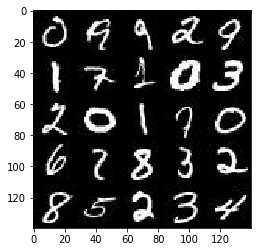

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

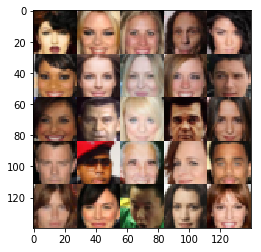

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_in_place = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels], name='real_input')
    z_place = tf.placeholder(tf.float32, [None, z_dim], name='z')
    lr_place = tf.placeholder(tf.float32, name='lr')

    return real_in_place, z_place, lr_place


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [10]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    initial_filter = 64
    conv_layers = 3
    filters = [initial_filter * (2**layer) for layer in range(conv_layers)]
    kernels = 5
    strides = 2
    padding = 'same'
    alpha = 0.2
    x = images
    
    with tf.variable_scope('discriminator', reuse=reuse):
        for i in range(len(filters)):
            if i == 0:
                x = tf.layers.conv2d(images, filters[i], kernels, strides=strides, padding=padding
                                      , kernel_initializer=tf.contrib.layers.xavier_initializer())
                x = tf.maximum(alpha * x, x)
            else:
                x = tf.layers.conv2d(x, filters[i], kernels, strides=strides, padding=padding
                                      , kernel_initializer=tf.contrib.layers.xavier_initializer())
                x = tf.layers.batch_normalization(x, training=True)
                x = tf.maximum(alpha * x, x)
        
        _, width, height, channel_dims = x.get_shape().as_list()
        
        flat = tf.reshape(x, [-1, width * height * filters[-1]])
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
            
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    width = 7
    height = 7
    transpose_layers = 3 # must be at least 3
    initial_depth = 512
    depths = [initial_depth * (2**layer) for layer in range(transpose_layers)]
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=not is_train):
        for i in range(len(depths)):
            if i == 0:
                
        g1 = tf.layers.dense(z, width * height * 512, activation=None)
        g1 = tf.reshape(g1, [-1, width, height, 512])
        g1 = tf.layers.batch_normalization(g1, training=is_train)
        g1 = tf.maximum(alpha * g1, g1)

        g2 = tf.layers.conv2d_transpose(g1, 256, 5, strides=1, padding='same')
        g2 = tf.layers.batch_normalization(g2, training=is_train)
        g2 = tf.maximum(alpha * g2, g2)
        
        g3 = tf.layers.conv2d_transpose(g2, 128, 5, strides=2, padding='same')
        g3 = tf.layers.batch_normalization(g3, training=is_train)
        g3 = tf.maximum(alpha * g3, g3)
        
        logits = tf.layers.conv2d_transpose(g3, out_channel_dim, 5, strides=2, padding='same')
        output = tf.tanh(logits)
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.9
    g_model = generator(input_z, out_channel_dim)
    d_logits_real, d_model_real = discriminator(input_real)
    d_logits_fake, d_model_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * smooth))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
#     saver = tf.train.Saver()
    samples, losses = [], []
    steps = 0
    print_every = 10
    show_every = 100
    n_images = 25
    
    _, width, height, channel_dims = data_shape
    
    input_real, z, lr = model_inputs(width, height, channel_dims, z_dim)
    
    d_loss, g_loss = model_loss(input_real, z, channel_dims)
    
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=[batch_size, z_dim])
                
                # Optimize
                _ = sess.run(d_opt, feed_dict={input_real: batch_images
                                               , z: batch_z
                                               , lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={z: batch_z
                                               , input_real: batch_images
                                               , lr: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({z: batch_z
                                                , input_real: batch_images})
                    train_loss_g = g_loss.eval({z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, z, channel_dims, data_image_mode)
#         saver.save(sess, './checkpoints/generator.ckpt')

                    

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.1685... Generator Loss: 0.6487
Epoch 1/2... Discriminator Loss: 1.1696... Generator Loss: 0.6546
Epoch 1/2... Discriminator Loss: 1.2471... Generator Loss: 0.6042
Epoch 1/2... Discriminator Loss: 1.1694... Generator Loss: 0.6644
Epoch 1/2... Discriminator Loss: 1.2489... Generator Loss: 0.6010
Epoch 1/2... Discriminator Loss: 1.1448... Generator Loss: 0.6917
Epoch 1/2... Discriminator Loss: 1.1964... Generator Loss: 0.6219
Epoch 1/2... Discriminator Loss: 1.1569... Generator Loss: 0.6931
Epoch 1/2... Discriminator Loss: 1.1315... Generator Loss: 0.6762
Epoch 1/2... Discriminator Loss: 1.1251... Generator Loss: 0.6838


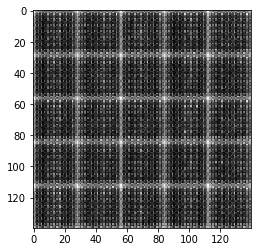

Epoch 1/2... Discriminator Loss: 1.1174... Generator Loss: 0.6865
Epoch 1/2... Discriminator Loss: 1.1218... Generator Loss: 0.6833
Epoch 1/2... Discriminator Loss: 1.1207... Generator Loss: 0.6841
Epoch 1/2... Discriminator Loss: 1.1135... Generator Loss: 0.6906
Epoch 1/2... Discriminator Loss: 1.1349... Generator Loss: 0.6783
Epoch 1/2... Discriminator Loss: 1.1107... Generator Loss: 0.6901
Epoch 1/2... Discriminator Loss: 1.1066... Generator Loss: 0.6931
Epoch 1/2... Discriminator Loss: 1.1066... Generator Loss: 0.6931
Epoch 1/2... Discriminator Loss: 1.1071... Generator Loss: 0.6926
Epoch 1/2... Discriminator Loss: 1.1086... Generator Loss: 0.6912


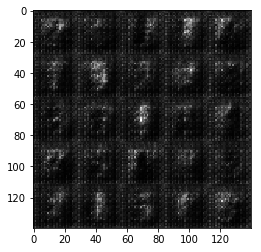

Epoch 1/2... Discriminator Loss: 1.1632... Generator Loss: 0.6625
Epoch 1/2... Discriminator Loss: 1.1805... Generator Loss: 0.6414
Epoch 1/2... Discriminator Loss: 1.2491... Generator Loss: 0.6927
Epoch 1/2... Discriminator Loss: 1.3509... Generator Loss: 0.6925
Epoch 1/2... Discriminator Loss: 1.3258... Generator Loss: 0.6398
Epoch 1/2... Discriminator Loss: 1.3012... Generator Loss: 0.6299
Epoch 1/2... Discriminator Loss: 1.3137... Generator Loss: 0.6892
Epoch 1/2... Discriminator Loss: 1.3167... Generator Loss: 0.6124
Epoch 1/2... Discriminator Loss: 1.4293... Generator Loss: 0.5292
Epoch 1/2... Discriminator Loss: 1.4101... Generator Loss: 0.6021


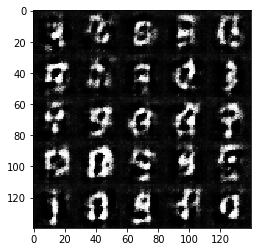

Epoch 1/2... Discriminator Loss: 1.3540... Generator Loss: 0.6270
Epoch 1/2... Discriminator Loss: 1.3813... Generator Loss: 0.6925
Epoch 1/2... Discriminator Loss: 1.3602... Generator Loss: 0.6851
Epoch 1/2... Discriminator Loss: 1.4707... Generator Loss: 0.4985
Epoch 1/2... Discriminator Loss: 1.4816... Generator Loss: 0.5046
Epoch 1/2... Discriminator Loss: 1.3817... Generator Loss: 0.6928
Epoch 1/2... Discriminator Loss: 1.3409... Generator Loss: 0.6183
Epoch 1/2... Discriminator Loss: 1.3590... Generator Loss: 0.6786
Epoch 1/2... Discriminator Loss: 1.3457... Generator Loss: 0.6399
Epoch 1/2... Discriminator Loss: 1.3815... Generator Loss: 0.5999


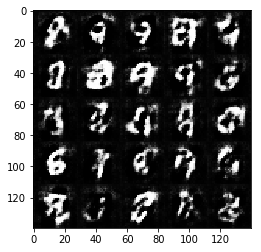

Epoch 1/2... Discriminator Loss: 1.2853... Generator Loss: 0.6500
Epoch 1/2... Discriminator Loss: 1.3417... Generator Loss: 0.6589
Epoch 1/2... Discriminator Loss: 1.5673... Generator Loss: 0.4068
Epoch 1/2... Discriminator Loss: 1.3216... Generator Loss: 0.6524
Epoch 1/2... Discriminator Loss: 1.3693... Generator Loss: 0.6247
Epoch 1/2... Discriminator Loss: 1.3510... Generator Loss: 0.6320
Epoch 1/2... Discriminator Loss: 1.2771... Generator Loss: 0.6307
Epoch 1/2... Discriminator Loss: 1.3853... Generator Loss: 0.6931
Epoch 1/2... Discriminator Loss: 1.3854... Generator Loss: 0.6931
Epoch 1/2... Discriminator Loss: 1.3799... Generator Loss: 0.6931


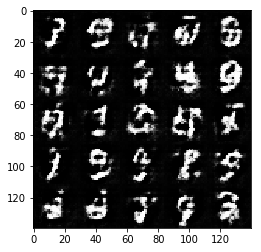

Epoch 1/2... Discriminator Loss: 1.3419... Generator Loss: 0.6786
Epoch 1/2... Discriminator Loss: 1.2575... Generator Loss: 0.6420
Epoch 1/2... Discriminator Loss: 1.3724... Generator Loss: 0.6929
Epoch 1/2... Discriminator Loss: 1.2854... Generator Loss: 0.6862
Epoch 1/2... Discriminator Loss: 1.3719... Generator Loss: 0.5207
Epoch 1/2... Discriminator Loss: 1.3255... Generator Loss: 0.5949
Epoch 1/2... Discriminator Loss: 1.2544... Generator Loss: 0.6550
Epoch 1/2... Discriminator Loss: 1.2984... Generator Loss: 0.6293
Epoch 1/2... Discriminator Loss: 1.3611... Generator Loss: 0.6577
Epoch 1/2... Discriminator Loss: 1.2953... Generator Loss: 0.6068


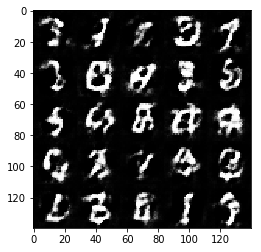

Epoch 1/2... Discriminator Loss: 1.2794... Generator Loss: 0.6887
Epoch 1/2... Discriminator Loss: 1.3690... Generator Loss: 0.6923
Epoch 1/2... Discriminator Loss: 1.2932... Generator Loss: 0.6158
Epoch 1/2... Discriminator Loss: 1.2725... Generator Loss: 0.6364
Epoch 1/2... Discriminator Loss: 1.3393... Generator Loss: 0.5665
Epoch 1/2... Discriminator Loss: 1.2842... Generator Loss: 0.6653
Epoch 1/2... Discriminator Loss: 1.2566... Generator Loss: 0.6174
Epoch 1/2... Discriminator Loss: 1.3926... Generator Loss: 0.5504
Epoch 1/2... Discriminator Loss: 1.3296... Generator Loss: 0.6907
Epoch 1/2... Discriminator Loss: 1.3298... Generator Loss: 0.5663


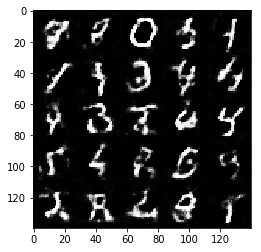

Epoch 1/2... Discriminator Loss: 1.3243... Generator Loss: 0.6897
Epoch 1/2... Discriminator Loss: 1.2967... Generator Loss: 0.6042
Epoch 1/2... Discriminator Loss: 1.3740... Generator Loss: 0.5634
Epoch 1/2... Discriminator Loss: 1.3988... Generator Loss: 0.5280
Epoch 1/2... Discriminator Loss: 1.3697... Generator Loss: 0.5531
Epoch 1/2... Discriminator Loss: 1.3160... Generator Loss: 0.6098
Epoch 1/2... Discriminator Loss: 1.3066... Generator Loss: 0.5882
Epoch 1/2... Discriminator Loss: 1.2955... Generator Loss: 0.6227
Epoch 1/2... Discriminator Loss: 1.4597... Generator Loss: 0.4640
Epoch 1/2... Discriminator Loss: 1.3205... Generator Loss: 0.6396


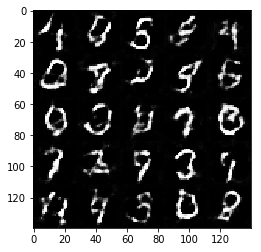

Epoch 1/2... Discriminator Loss: 1.3069... Generator Loss: 0.5830
Epoch 1/2... Discriminator Loss: 1.3102... Generator Loss: 0.6025
Epoch 1/2... Discriminator Loss: 1.3465... Generator Loss: 0.6855
Epoch 1/2... Discriminator Loss: 1.3424... Generator Loss: 0.6815
Epoch 1/2... Discriminator Loss: 1.3624... Generator Loss: 0.5665
Epoch 1/2... Discriminator Loss: 1.3916... Generator Loss: 0.5190
Epoch 1/2... Discriminator Loss: 1.4022... Generator Loss: 0.5084
Epoch 1/2... Discriminator Loss: 1.2850... Generator Loss: 0.6809
Epoch 1/2... Discriminator Loss: 1.3334... Generator Loss: 0.5896
Epoch 1/2... Discriminator Loss: 1.4307... Generator Loss: 0.5186


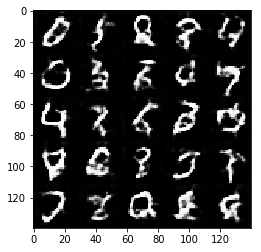

Epoch 1/2... Discriminator Loss: 1.3018... Generator Loss: 0.6762
Epoch 1/2... Discriminator Loss: 1.3543... Generator Loss: 0.5445
Epoch 1/2... Discriminator Loss: 1.4926... Generator Loss: 0.4671
Epoch 2/2... Discriminator Loss: 1.2583... Generator Loss: 0.6726
Epoch 2/2... Discriminator Loss: 1.3668... Generator Loss: 0.6911
Epoch 2/2... Discriminator Loss: 1.3799... Generator Loss: 0.5278
Epoch 2/2... Discriminator Loss: 1.2900... Generator Loss: 0.6212
Epoch 2/2... Discriminator Loss: 1.3123... Generator Loss: 0.6276
Epoch 2/2... Discriminator Loss: 1.3159... Generator Loss: 0.5797
Epoch 2/2... Discriminator Loss: 1.2921... Generator Loss: 0.6398


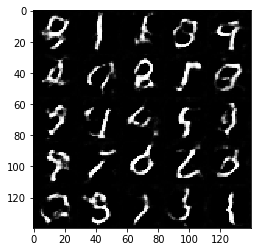

Epoch 2/2... Discriminator Loss: 1.4381... Generator Loss: 0.4792
Epoch 2/2... Discriminator Loss: 1.3290... Generator Loss: 0.5987
Epoch 2/2... Discriminator Loss: 1.2768... Generator Loss: 0.6713
Epoch 2/2... Discriminator Loss: 1.2903... Generator Loss: 0.6316
Epoch 2/2... Discriminator Loss: 1.3879... Generator Loss: 0.5269
Epoch 2/2... Discriminator Loss: 1.2804... Generator Loss: 0.6657
Epoch 2/2... Discriminator Loss: 1.3692... Generator Loss: 0.5442
Epoch 2/2... Discriminator Loss: 1.2963... Generator Loss: 0.6666
Epoch 2/2... Discriminator Loss: 1.2972... Generator Loss: 0.5987
Epoch 2/2... Discriminator Loss: 1.2831... Generator Loss: 0.6151


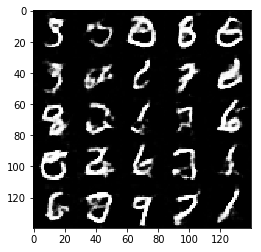

Epoch 2/2... Discriminator Loss: 1.3211... Generator Loss: 0.5808
Epoch 2/2... Discriminator Loss: 1.2995... Generator Loss: 0.6440
Epoch 2/2... Discriminator Loss: 1.2630... Generator Loss: 0.6573
Epoch 2/2... Discriminator Loss: 1.3451... Generator Loss: 0.6897
Epoch 2/2... Discriminator Loss: 1.4141... Generator Loss: 0.4907
Epoch 2/2... Discriminator Loss: 1.3992... Generator Loss: 0.5057
Epoch 2/2... Discriminator Loss: 1.2588... Generator Loss: 0.6478
Epoch 2/2... Discriminator Loss: 1.2846... Generator Loss: 0.6861
Epoch 2/2... Discriminator Loss: 1.2897... Generator Loss: 0.6850
Epoch 2/2... Discriminator Loss: 1.3192... Generator Loss: 0.5761


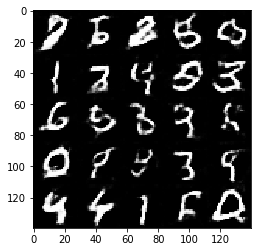

Epoch 2/2... Discriminator Loss: 1.4716... Generator Loss: 0.4556
Epoch 2/2... Discriminator Loss: 1.2490... Generator Loss: 0.6592
Epoch 2/2... Discriminator Loss: 1.3280... Generator Loss: 0.5719
Epoch 2/2... Discriminator Loss: 1.2524... Generator Loss: 0.6524
Epoch 2/2... Discriminator Loss: 1.3991... Generator Loss: 0.5087
Epoch 2/2... Discriminator Loss: 1.2508... Generator Loss: 0.6462
Epoch 2/2... Discriminator Loss: 1.2759... Generator Loss: 0.5948
Epoch 2/2... Discriminator Loss: 1.2763... Generator Loss: 0.6842
Epoch 2/2... Discriminator Loss: 1.2266... Generator Loss: 0.6331
Epoch 2/2... Discriminator Loss: 1.3516... Generator Loss: 0.5261


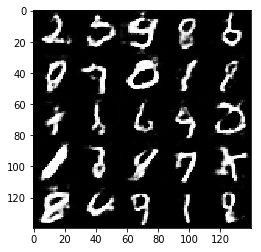

Epoch 2/2... Discriminator Loss: 1.2679... Generator Loss: 0.6902
Epoch 2/2... Discriminator Loss: 1.2413... Generator Loss: 0.6641
Epoch 2/2... Discriminator Loss: 1.3553... Generator Loss: 0.5328
Epoch 2/2... Discriminator Loss: 1.3289... Generator Loss: 0.5511
Epoch 2/2... Discriminator Loss: 1.2766... Generator Loss: 0.5938
Epoch 2/2... Discriminator Loss: 1.2204... Generator Loss: 0.6349
Epoch 2/2... Discriminator Loss: 1.2362... Generator Loss: 0.6745
Epoch 2/2... Discriminator Loss: 1.2775... Generator Loss: 0.5832
Epoch 2/2... Discriminator Loss: 1.4476... Generator Loss: 0.4594
Epoch 2/2... Discriminator Loss: 1.2188... Generator Loss: 0.6864


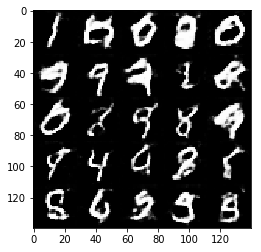

Epoch 2/2... Discriminator Loss: 1.3206... Generator Loss: 0.5475
Epoch 2/2... Discriminator Loss: 1.2106... Generator Loss: 0.6850
Epoch 2/2... Discriminator Loss: 1.2454... Generator Loss: 0.6082
Epoch 2/2... Discriminator Loss: 1.2085... Generator Loss: 0.6467
Epoch 2/2... Discriminator Loss: 1.2425... Generator Loss: 0.6878
Epoch 2/2... Discriminator Loss: 1.2002... Generator Loss: 0.6267
Epoch 2/2... Discriminator Loss: 1.2098... Generator Loss: 0.6694
Epoch 2/2... Discriminator Loss: 1.2940... Generator Loss: 0.6915
Epoch 2/2... Discriminator Loss: 1.2112... Generator Loss: 0.6270
Epoch 2/2... Discriminator Loss: 1.2434... Generator Loss: 0.6023


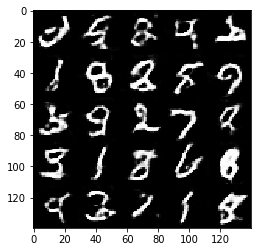

Epoch 2/2... Discriminator Loss: 1.3433... Generator Loss: 0.5320
Epoch 2/2... Discriminator Loss: 1.2105... Generator Loss: 0.6435
Epoch 2/2... Discriminator Loss: 1.1674... Generator Loss: 0.6645
Epoch 2/2... Discriminator Loss: 1.2400... Generator Loss: 0.6034
Epoch 2/2... Discriminator Loss: 1.2888... Generator Loss: 0.6916
Epoch 2/2... Discriminator Loss: 1.2828... Generator Loss: 0.5726
Epoch 2/2... Discriminator Loss: 1.1689... Generator Loss: 0.6736
Epoch 2/2... Discriminator Loss: 1.2827... Generator Loss: 0.5742
Epoch 2/2... Discriminator Loss: 1.4712... Generator Loss: 0.4415
Epoch 2/2... Discriminator Loss: 1.2446... Generator Loss: 0.5953


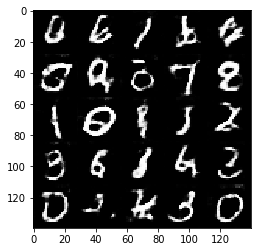

Epoch 2/2... Discriminator Loss: 1.5489... Generator Loss: 0.3967
Epoch 2/2... Discriminator Loss: 1.1791... Generator Loss: 0.6519
Epoch 2/2... Discriminator Loss: 1.1588... Generator Loss: 0.6796
Epoch 2/2... Discriminator Loss: 1.1747... Generator Loss: 0.6645
Epoch 2/2... Discriminator Loss: 1.1985... Generator Loss: 0.6733
Epoch 2/2... Discriminator Loss: 1.1856... Generator Loss: 0.6878
Epoch 2/2... Discriminator Loss: 1.1787... Generator Loss: 0.6426
Epoch 2/2... Discriminator Loss: 1.4352... Generator Loss: 0.4639
Epoch 2/2... Discriminator Loss: 1.4231... Generator Loss: 0.4714
Epoch 2/2... Discriminator Loss: 1.3841... Generator Loss: 0.4960


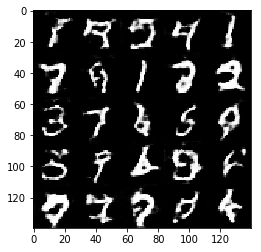

Epoch 2/2... Discriminator Loss: 1.2038... Generator Loss: 0.6200
Epoch 2/2... Discriminator Loss: 1.2847... Generator Loss: 0.5666
Epoch 2/2... Discriminator Loss: 1.3835... Generator Loss: 0.4952
Epoch 2/2... Discriminator Loss: 1.1934... Generator Loss: 0.6846
Epoch 2/2... Discriminator Loss: 1.2299... Generator Loss: 0.6093
Epoch 2/2... Discriminator Loss: 1.1952... Generator Loss: 0.6469
Epoch 2/2... Discriminator Loss: 1.3803... Generator Loss: 0.4949
Epoch 2/2... Discriminator Loss: 1.4765... Generator Loss: 0.4383
Epoch 2/2... Discriminator Loss: 1.2078... Generator Loss: 0.6920
Epoch 2/2... Discriminator Loss: 1.2555... Generator Loss: 0.5823


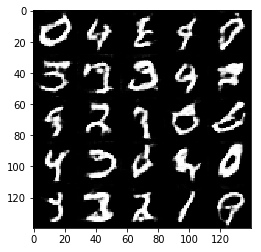

Epoch 2/2... Discriminator Loss: 1.2283... Generator Loss: 0.6199
Epoch 2/2... Discriminator Loss: 1.2922... Generator Loss: 0.5624
Epoch 2/2... Discriminator Loss: 1.2217... Generator Loss: 0.6130
Epoch 2/2... Discriminator Loss: 1.3597... Generator Loss: 0.5115
Epoch 2/2... Discriminator Loss: 1.3205... Generator Loss: 0.5391
Epoch 2/2... Discriminator Loss: 1.1877... Generator Loss: 0.6787
Epoch 2/2... Discriminator Loss: 1.3241... Generator Loss: 0.5385


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.2052... Generator Loss: 0.6460
Epoch 1/1... Discriminator Loss: 1.1672... Generator Loss: 0.6592
Epoch 1/1... Discriminator Loss: 1.1800... Generator Loss: 0.6432
Epoch 1/1... Discriminator Loss: 1.1513... Generator Loss: 0.6651
Epoch 1/1... Discriminator Loss: 1.1327... Generator Loss: 0.6867
Epoch 1/1... Discriminator Loss: 1.1359... Generator Loss: 0.6829
Epoch 1/1... Discriminator Loss: 1.1255... Generator Loss: 0.6832
Epoch 1/1... Discriminator Loss: 1.1405... Generator Loss: 0.6704
Epoch 1/1... Discriminator Loss: 1.1382... Generator Loss: 0.6770
Epoch 1/1... Discriminator Loss: 1.1259... Generator Loss: 0.6798


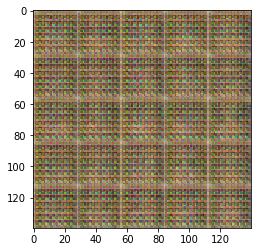

Epoch 1/1... Discriminator Loss: 1.1867... Generator Loss: 0.6381
Epoch 1/1... Discriminator Loss: 1.2087... Generator Loss: 0.6232
Epoch 1/1... Discriminator Loss: 1.1246... Generator Loss: 0.6835
Epoch 1/1... Discriminator Loss: 1.2575... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.1832... Generator Loss: 0.6767
Epoch 1/1... Discriminator Loss: 1.1865... Generator Loss: 0.6697
Epoch 1/1... Discriminator Loss: 1.3011... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.2499... Generator Loss: 0.6429
Epoch 1/1... Discriminator Loss: 1.2207... Generator Loss: 0.6886
Epoch 1/1... Discriminator Loss: 1.1875... Generator Loss: 0.6629


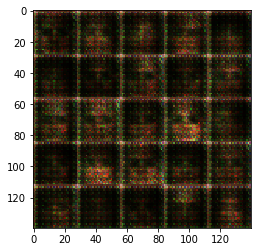

Epoch 1/1... Discriminator Loss: 1.2301... Generator Loss: 0.6885
Epoch 1/1... Discriminator Loss: 1.1870... Generator Loss: 0.6708
Epoch 1/1... Discriminator Loss: 1.1827... Generator Loss: 0.6593
Epoch 1/1... Discriminator Loss: 1.3520... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.1508... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 1.2156... Generator Loss: 0.6706
Epoch 1/1... Discriminator Loss: 1.2366... Generator Loss: 0.6783
Epoch 1/1... Discriminator Loss: 1.1304... Generator Loss: 0.6857
Epoch 1/1... Discriminator Loss: 1.2298... Generator Loss: 0.6554
Epoch 1/1... Discriminator Loss: 1.1911... Generator Loss: 0.6781


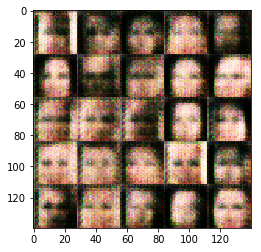

Epoch 1/1... Discriminator Loss: 1.2020... Generator Loss: 0.6907
Epoch 1/1... Discriminator Loss: 1.1796... Generator Loss: 0.6523
Epoch 1/1... Discriminator Loss: 1.1982... Generator Loss: 0.6698
Epoch 1/1... Discriminator Loss: 1.2696... Generator Loss: 0.6912
Epoch 1/1... Discriminator Loss: 1.2752... Generator Loss: 0.6840
Epoch 1/1... Discriminator Loss: 1.2859... Generator Loss: 0.6851
Epoch 1/1... Discriminator Loss: 1.3217... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.1343... Generator Loss: 0.6921
Epoch 1/1... Discriminator Loss: 1.1364... Generator Loss: 0.6815
Epoch 1/1... Discriminator Loss: 1.1575... Generator Loss: 0.6628


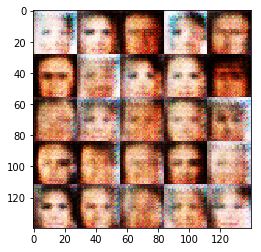

Epoch 1/1... Discriminator Loss: 1.3227... Generator Loss: 0.6817
Epoch 1/1... Discriminator Loss: 1.4763... Generator Loss: 0.4843
Epoch 1/1... Discriminator Loss: 1.1411... Generator Loss: 0.6728
Epoch 1/1... Discriminator Loss: 1.2135... Generator Loss: 0.6512
Epoch 1/1... Discriminator Loss: 1.5611... Generator Loss: 0.4445
Epoch 1/1... Discriminator Loss: 1.2342... Generator Loss: 0.6431
Epoch 1/1... Discriminator Loss: 1.3034... Generator Loss: 0.6504
Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 0.5212
Epoch 1/1... Discriminator Loss: 1.4423... Generator Loss: 0.4820
Epoch 1/1... Discriminator Loss: 1.3657... Generator Loss: 0.6012


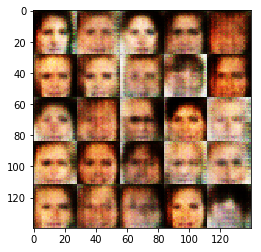

Epoch 1/1... Discriminator Loss: 1.3080... Generator Loss: 0.6070
Epoch 1/1... Discriminator Loss: 1.2566... Generator Loss: 0.6065
Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.5742
Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.6115
Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.6799
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.6905
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.6848
Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.6918
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.6913
Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 0.6916


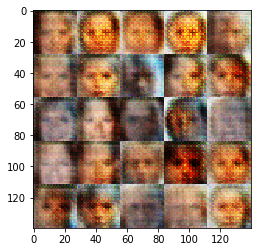

Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.6926
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.6927
Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 0.6924
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.6927
Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.6928
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6930


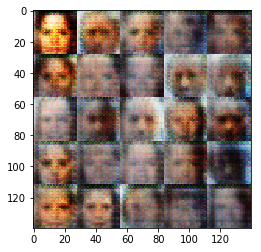

Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6930


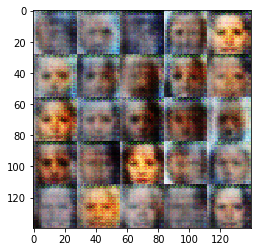

Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6931


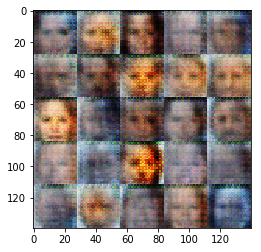

Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931


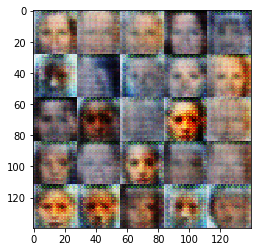

Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6930


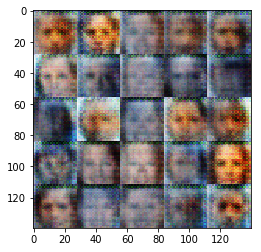

Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6931


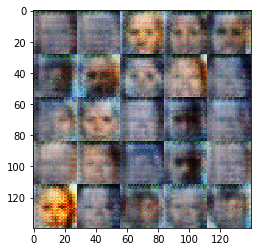

Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931


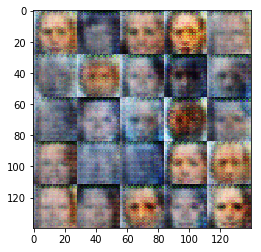

Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931


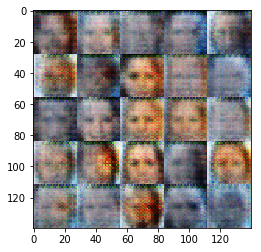

Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931


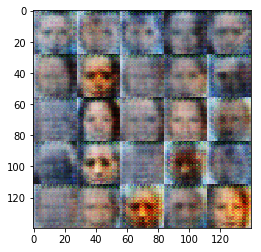

Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931


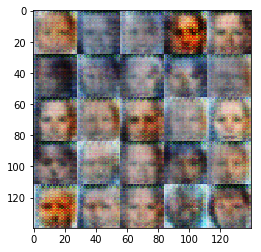

Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931


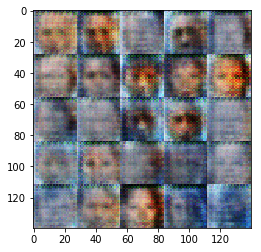

Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931


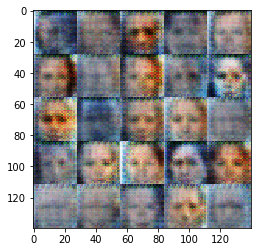

Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931


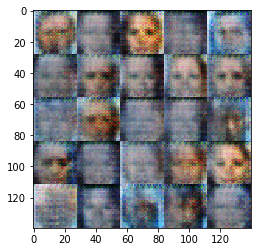

Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931


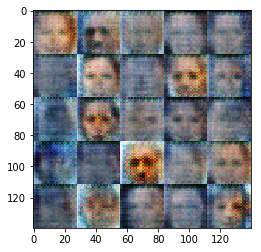

Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931


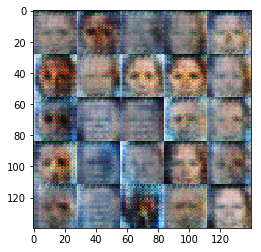

Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931


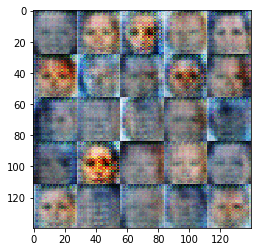

Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931


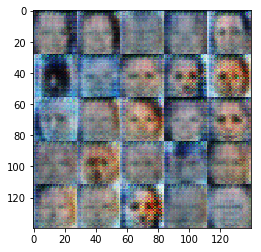

Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931


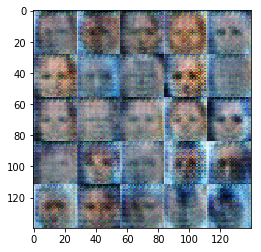

Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931


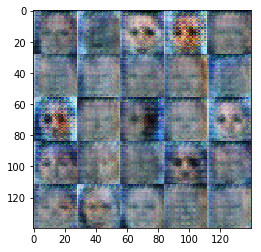

Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931


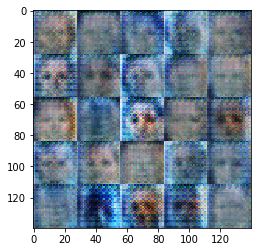

Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931


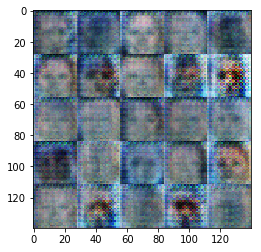

Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931


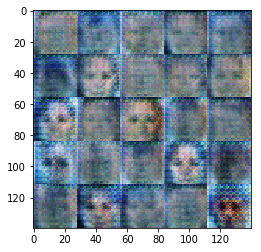

Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931


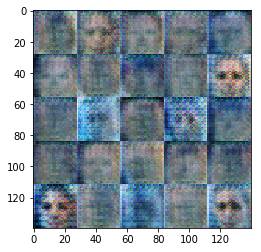

Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931


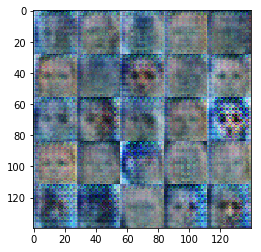

Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931


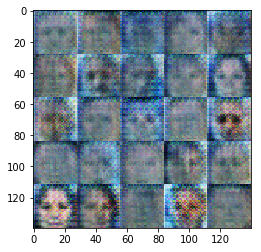

Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.